# Практическая работа №6
## Кластеризация

### Импорт необходимых библиотек

In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_wine, load_iris
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch, \
    MeanShift, SpectralClustering, AffinityPropagation
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, \
    homogeneity_score, completeness_score, v_measure_score, silhouette_score, \
    jaccard_score, fowlkes_mallows_score, davies_bouldin_score
from sklearn.model_selection import train_test_split, ParameterGrid

from functions import visualization_with_pca, plot_histogram


warnings.filterwarnings('ignore')

In [2]:
dataframe_train = load_wine(as_frame=True).frame
dataframe_train

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


Выведем информацию о таблицах.

In [3]:
dataframe_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [4]:
dataframe_train.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

Из вывода видно, что в столбцах нет пустых значений.

In [5]:
class_labels_train = dataframe_train['target']
number_of_classes = class_labels_train.nunique()
print(f"Число классов: {number_of_classes}")

Число классов: 3


Удалим из датафрейма метки классов.

In [6]:
dataframe_train.drop('target', axis=1, inplace=True)

In [7]:
dataframe_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

Произведём нормирование всех числовых признаков

In [8]:
min_max_scaler = MinMaxScaler()
dataframe_train = min_max_scaler.fit_transform(dataframe_train)

In [9]:
x = dataframe_train
y = class_labels_train

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)

### Кластеризация данных с помощью метода k-means
Визуализируем данные без кластеризации

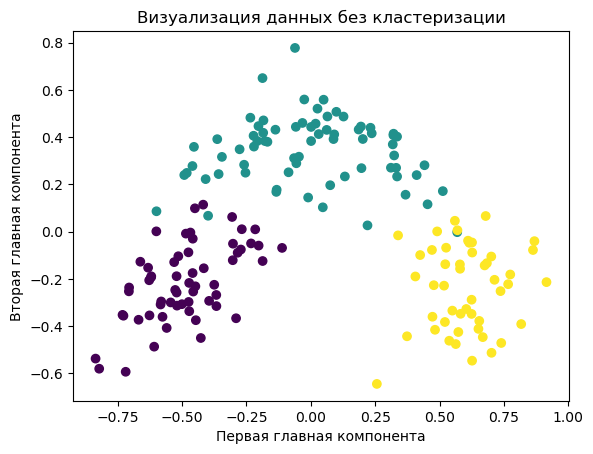

In [10]:
visualization_with_pca(x, y, "Визуализация данных без кластеризации", )

Выполним кластеризацию данных с помощью алгоритма k-means. Количество кластеров будет равным числу классов.

In [11]:
kmeans = KMeans(n_clusters=number_of_classes, random_state=42).fit(x)

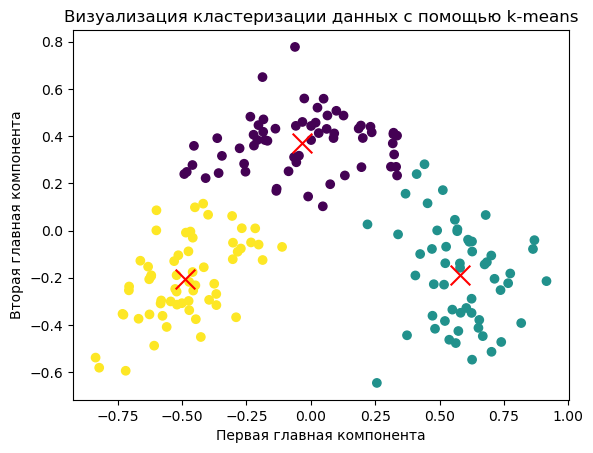

In [12]:
visualization_with_pca(x, kmeans.labels_,
                       "Визуализация кластеризации данных с помощью k-means",
                       kmeans.cluster_centers_)

Оценим качество решения задачи по метрикам оценки качества кластеризации.

In [13]:
def count_scores(x, y_true, y_pred):
    print(
        f"Adjusted Rand index: {round(adjusted_rand_score(y_true, y_pred), 3)}\n"
        f"Adjusted Mutual Information: {round(adjusted_mutual_info_score(y_true, y_pred), 3)}\n"
        f"Homogeneity: {round(homogeneity_score(y_true, y_pred), 3)}\n"
        f"Completeness: {round(completeness_score(y_true, y_pred), 3)}\n"
        f"V-measure: {round(v_measure_score(y_true, y_pred), 3)}\n"
        f"Silhouette: {round(silhouette_score(x, y_pred), 3)}\n"
        f"Jaccard index: {round(jaccard_score(y_true, y_pred, average='macro'), 3)}\n"
        f"Fowlkes-Mallows index: {round(fowlkes_mallows_score(y_true, y_pred), 3)}\n"
        f"Davies-Bouldin index: {round(davies_bouldin_score(x, y_pred), 3)}")

In [14]:
count_scores(x, y, kmeans.labels_)

Adjusted Rand index: 0.854
Adjusted Mutual Information: 0.84
Homogeneity: 0.846
Completeness: 0.837
V-measure: 0.842
Silhouette: 0.301
Jaccard index: 0.02
Fowlkes-Mallows index: 0.903
Davies-Bouldin index: 1.309


Используя "правило локтя", подберём оптимальное количество кластеров

In [15]:
def elbow_rule(x):
    # Создаем список для хранения значений SSE
    sse = []

    # Перебираем возможные значения числа кластеров от 2 до 10
    for k in range(2, 11):
        # Создаем объект KMeans с текущим числом кластеров
        kmeans = KMeans(n_clusters=k, random_state=42)
        # Обучаем модель на данных
        kmeans.fit(x)
        # Добавляем значение SSE в список
        sse.append(kmeans.inertia_)

    # Строим график зависимости SSE от числа кластеров
    plt.plot(range(2, 11), sse, marker="o")
    plt.xlabel('$k$')
    plt.ylabel('$J(C_k)$')
    plt.title("Метод локтя")
    plt.show()

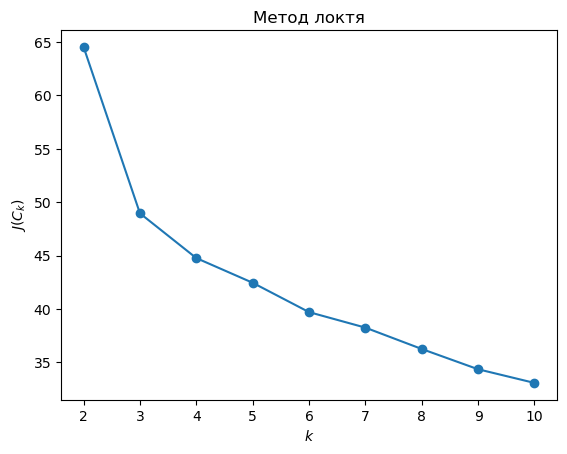

In [16]:
elbow_rule(x)

По графику видно, что оптимальное количество кластеров равно 3, так как снижение внутрикластерной дисперсии в этой точке замедляется.

### Кластеризация данных с помощью метода AgglomerativeClustering

In [17]:
def train_agglomerative_clustering(x, y, param_grid):
    # Инициализируем лучший силуэт и лучшие параметры
    best_silhouette = -1
    best_params = None

    # Перебираем все комбинации параметров из сетки
    for params in ParameterGrid(param_grid):
        # Создаем экземпляр модели AgglomerativeClustering с текущими параметрами и применяем модель к данным
        agg = AgglomerativeClustering(**params).fit(x)

        # Получаем метки кластеров
        labels = agg.labels_

        # Вычисляем силуэт для текущей модели
        silhouette = silhouette_score(x, labels)

        # Сравниваем силуэт с лучшим силуэтом и обновляем лучшие параметры при необходимости
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_params = params

    agg = AgglomerativeClustering(**best_params).fit(x)
    labels = agg.labels_

    n_clusters = agg.n_clusters

    visualization_with_pca(x, labels,
                           "Визуализация кластеризации данных с помощью AgglomerativeClustering")

    print(f"Лучшие параметры модели:\n"
          f"n_clusters: {n_clusters}\n"
          f"affinity: {agg.affinity}\n"
          f"linkage: {agg.linkage}")

    count_scores(x, y, labels)

In [18]:
# Создаем сетку параметров для метода AgglomerativeClustering
agglomerative_grid = {
    'n_clusters': range(3, 7),  # количество кластеров
    'affinity': ['euclidean', 'manhattan', 'cosine'],  # метрика расстояния
    'linkage': ['complete', 'average', 'single']  # метод объединения кластеров
}

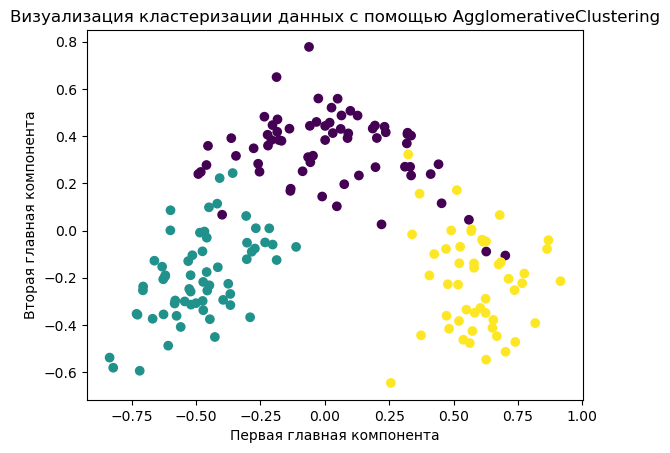

Лучшие параметры модели:
n_clusters: 3
affinity: manhattan
linkage: complete
Adjusted Rand index: 0.837
Adjusted Mutual Information: 0.799
Homogeneity: 0.803
Completeness: 0.8
V-measure: 0.801
Silhouette: 0.283
Jaccard index: 0.296
Fowlkes-Mallows index: 0.892
Davies-Bouldin index: 1.358


In [19]:
train_agglomerative_clustering(x, y, agglomerative_grid)

### Кластеризация данных с помощью Birch

In [20]:
def train_birch_clustering(x, y, param_grid):
    # Инициализируем лучший силуэт и лучший параметр threshold
    best_silhouette = -1
    best_params = None
    # Перебираем все значения threshold из сетки
    for params in ParameterGrid(param_grid):

        try:
            # Создаем экземпляр модели Birch с текущим значением threshold и применяем модель к данным
            birch = Birch(**params).fit(x)

        except ValueError:
            continue

        # Получаем метки кластеров
        labels = birch.labels_

        try:
            # Вычисляем силуэт для текущей модели
            silhouette = silhouette_score(x, labels)

            # Сравниваем силуэт с лучшим силуэтом и обновляем лучший параметр при необходимости
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_params = params

        except ValueError:
            pass

    # Создаем экземпляр модели Birch с лучшим значением threshold и применяем модель к данным
    birch = Birch(**best_params).fit(x)
    labels = birch.labels_

    visualization_with_pca(x, labels,
                           "Визуализация кластеризации данных с помощью Birch")

    print(f"Лучшие параметры модели:\n"
          f"n_clusters: {birch.n_clusters}\n"
          f"threshold: {birch.threshold}\n"
          f"branching_factor: {birch.branching_factor}")

    count_scores(x, y, labels)

In [21]:
# Создаем сетку параметров для метода Birch
birch_grid = {
    'threshold': [0.6],
    'branching_factor': range(50, 100, 10),
}

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


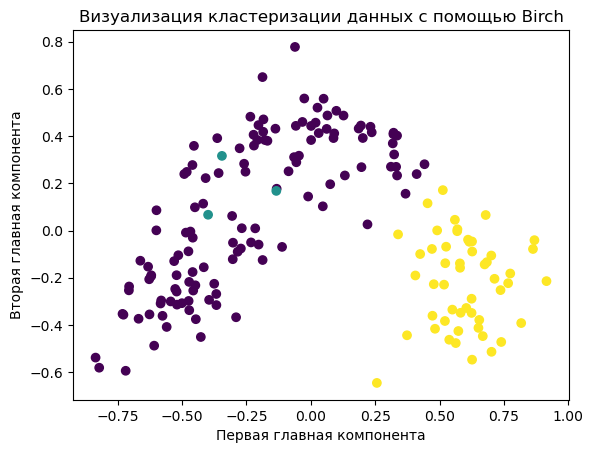

Лучшие параметры модели:
n_clusters: 3
threshold: 0.6
branching_factor: 50
Adjusted Rand index: 0.467
Adjusted Mutual Information: 0.606
Homogeneity: 0.497
Completeness: 0.795
V-measure: 0.612
Silhouette: 0.229
Jaccard index: 0.486
Fowlkes-Mallows index: 0.715
Davies-Bouldin index: 1.236


In [22]:
train_birch_clustering(x, y, birch_grid)

### Кластеризация данных с помощью метода MeanShift

In [23]:
def train_mean_shift(x, y, param_grid):
    # Инициализируем лучший силуэт и лучшие параметры
    best_silhouette = -1
    best_params = None

    # Перебираем все комбинации параметров из сетки
    for params in ParameterGrid(param_grid):

        try:
            # Создаем экземпляр модели MeanShift с текущими параметрами и применяем модель к данным
            ms = MeanShift(**params).fit(x)
        except ValueError:
            continue

        # Получаем метки кластеров
        labels = ms.labels_

        try:

            # Вычисляем силуэт для текущей модели
            silhouette = silhouette_score(x, labels)

            # Сравниваем силуэт с лучшим силуэтом и обновляем лучшие параметры при необходимости
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_params = params

        except ValueError:
            pass

    ms = MeanShift(**best_params).fit(x)
    labels = ms.labels_
    n_clusters = len(set(labels))
    cluster_centers = ms.cluster_centers_

    visualization_with_pca(x, labels,
                           "Визуализация кластеризации данных с помощью MeanShift",
                           cluster_centers)
    print(f"Лучшие параметры модели:\n"
          f"n_clusters: {n_clusters}\n"
          f"bin_seeding: {ms.bin_seeding}\n"
          f"min_bin_freq: {ms.min_bin_freq}\n"
          f"bandwidth: {ms.bandwidth}")
    count_scores(x, y, labels)

In [24]:
mean_shift_grid = {
    "bandwidth": [0.1, 0.2, 0.3, 0.4, 0.5, None],
    "n_jobs": [-1],
    "bin_seeding": [True, False],  # два варианта для параметра bin_seeding
    "min_bin_freq": np.arange(1, 50, 5)
    # диапазон значений для параметра min_bin_freq
}

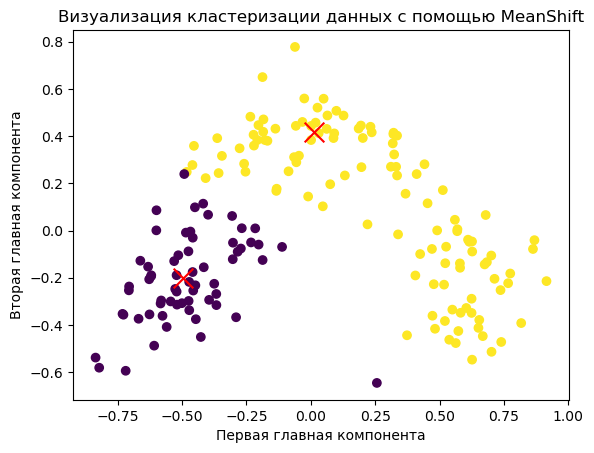

Лучшие параметры модели:
n_clusters: 2
bin_seeding: True
min_bin_freq: 6
bandwidth: 0.5
Adjusted Rand index: 0.544
Adjusted Mutual Information: 0.634
Homogeneity: 0.509
Completeness: 0.851
V-measure: 0.637
Silhouette: 0.257
Jaccard index: 0.504
Fowlkes-Mallows index: 0.754
Davies-Bouldin index: 1.401


In [25]:
train_mean_shift(x, y, mean_shift_grid)

### Кластеризация данных с помощью метода SpectralClustering

In [26]:
def train_spectral_clustering(x, y, param_grid):
    # Инициализируем лучший силуэт и лучшие параметры
    best_silhouette = -1
    best_params = None

    # Перебираем все комбинации параметров из сетки
    for params in ParameterGrid(param_grid):

        try:
            # Создаем экземпляр модели SpectralClustering с текущими параметрами и применяем модель к данным
            sc = SpectralClustering(**params).fit(x)
        except ValueError:
            continue

        # Получаем метки кластеров
        labels = sc.labels_

        try:

            # Вычисляем силуэт для текущей модели
            silhouette = silhouette_score(x, labels)

            # Сравниваем силуэт с лучшим силуэтом и обновляем лучшие параметры при необходимости
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_params = params

        except ValueError:
            pass

    sc = SpectralClustering(**best_params).fit(x)
    labels = sc.labels_

    visualization_with_pca(x, labels,
                           "Визуализация кластеризации данных с помощью SpectralClustering")
    print(f"Лучшие параметры модели:\n"
          f"n_clusters: {sc.n_clusters}\n"
          f"affinity: {sc.affinity}\n"
          f"n_neighbors: {sc.n_neighbors}\n"
          f"gamma: {sc.gamma}")
    count_scores(x, y, labels)

In [27]:
spectral_clustering_grid = {
    'n_clusters': range(3, 7),  # количество кластеров
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': range(5, 16, 2),
    'gamma': np.arange(0.1, 1.0, 0.2),
    'n_jobs': [-1]
}

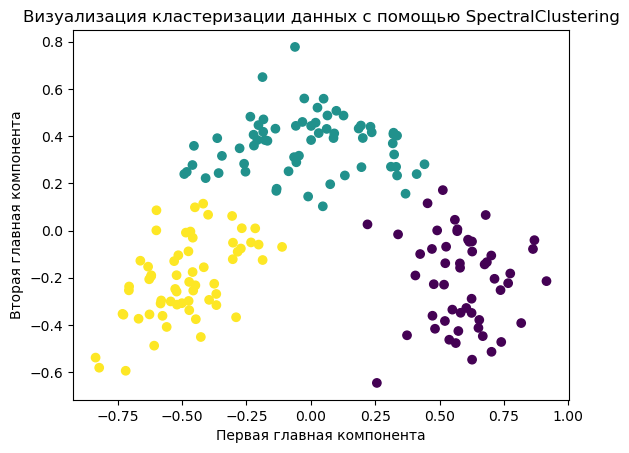

Лучшие параметры модели:
n_clusters: 3
affinity: nearest_neighbors
n_neighbors: 13
gamma: 0.1
Adjusted Rand index: 0.899
Adjusted Mutual Information: 0.877
Homogeneity: 0.882
Completeness: 0.875
V-measure: 0.878
Silhouette: 0.301
Jaccard index: 0.305
Fowlkes-Mallows index: 0.933
Davies-Bouldin index: 1.307


In [28]:
train_spectral_clustering(x, y, spectral_clustering_grid)

### Кластеризация данных с помощью метода AffinityPropagation

In [29]:
def train_affinity_propagation(x, y, param_grid):
    # Инициализируем лучший силуэт и лучшие параметры
    best_silhouette = -1
    best_params = None

    # Перебираем все комбинации параметров из сетки
    for params in ParameterGrid(param_grid):

        try:
            # Создаем экземпляр модели AffinityPropagation с текущими параметрами и применяем модель к данным
            ap = AffinityPropagation(**params).fit(x)
        except ValueError:
            continue

        # Получаем метки кластеров
        labels = ap.labels_

        try:
            # Вычисляем силуэт для текущей модели
            silhouette = silhouette_score(x, labels)
            # Сравниваем силуэт с лучшим силуэтом и обновляем лучшие параметры при необходимости
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_params = params
        except ValueError:
            pass

    ap = AffinityPropagation(**best_params).fit(x)
    labels = ap.labels_
    n_clusters = len(ap.cluster_centers_indices_)

    visualization_with_pca(x, labels, "Визуализация кластеризации данных с помощью AffinityPropagation", ap.cluster_centers_)

    print(f"Лучшие параметры модели:\n"
          f"n_clusters: {n_clusters}\n"
          f"damping: {ap.damping}\n"
          f"max_iter: {ap.max_iter}")
    count_scores(x, y, labels)

In [30]:
affinity_propagation_grid = {
    'damping': [0.5, 0.6, 0.7, 0.8, 0.9],
    'max_iter': [50, 100, 200, 500],
}

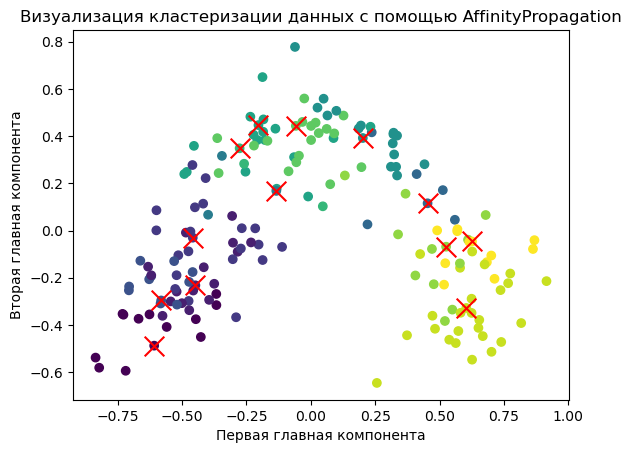

Лучшие параметры модели:
n_clusters: 13
damping: 0.8
max_iter: 50
Adjusted Rand index: 0.293
Adjusted Mutual Information: 0.533
Homogeneity: 0.896
Completeness: 0.4
V-measure: 0.553
Silhouette: 0.117
Jaccard index: 0.017
Fowlkes-Mallows index: 0.483
Davies-Bouldin index: 1.79


In [31]:
train_affinity_propagation(x, y, affinity_propagation_grid)

### Сравнение результатов

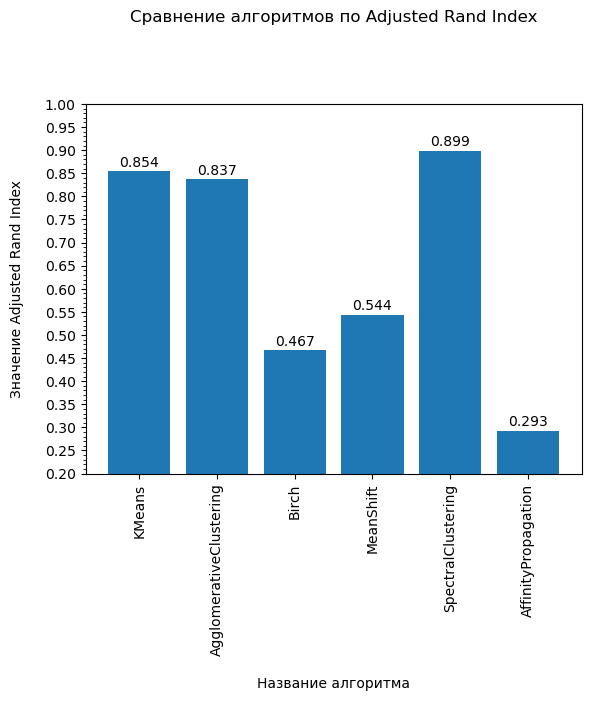

In [33]:
data = {
    "KMeans": 0.854,
    "AgglomerativeClustering": 0.837,
    "Birch": 0.467,
    "MeanShift": 0.544,
    "SpectralClustering": 0.899,
    "AffinityPropagation": 0.293,
}

plot_histogram(data, "Adjusted Rand Index")